# VIP Assignment 4, 2025
# Roland Laucis(bfn372), Joost Keiren(vgc483), Maria Thurn(dsh242), Diana Meda(klz764)

## Roland's understanding and explination of how this system will work:

SIFT calculates keypoints (e.g. 100+) for a grayscale image based on black magic we dont need to know. For each keypoint it calculates a descriptor. 

A descriptor is a 128-dim vector that represents 8 gradient orientations of 4x4 subgrid pixels around the pixel at a keypoint.

We dont care about the keypoint info here and also dont need to track which descriptors are for which image, when building the model.

This huge list of large dim vectors is (unsupervised & unlabled) clustered into groups by similarity of their 128-dim vector values. K-means clusering does the magic for us here. So each cluster contains a bunch of these vectors, that dont appear in the other clusters.

Each cluster can then be thought of as a unit of some unknown, abstract "meaning" that is different from the others - all the descriptors within it have something (vector values) in common.
The literature calls these units/clusters "visual words" as an analogy to NLP. So then we can create a "vocabulary" or collection of these k clusters.

#### The **main idea** is that a new given image can be analyzed by its descriptors, then count for each cluster how many of those descriptors fall into that cluster - a histogram. The training images would have their histograms pre-calculated and so we can compare all images with the given by their histograms, using Bhattacharyya distance or Kullback-Leibler divergence algorithms.

In [35]:
import cv2
import numpy as np
from sklearn.cluster import KMeans # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# built-in
from glob import glob
from pathlib import Path
import os
import random

In [36]:
sift = cv2.SIFT_create()

In [37]:
# load image paths only to save working memory
# images from the https://data.caltech.edu/records/mzrjq-6wc02 Caltech 101 dataset
# 21 selected categories, at least 1 test image from each category

# Get all image paths
img_paths = glob('Images/*/*.jpg')

# Get unique categories
cats = list(set(map(lambda jpg_path: Path(jpg_path).parts[1], img_paths))) # OS agnostic split

# Initialize lists for train and test images
train_imgs = []
test_imgs = []

# Split images in each category
for cat in cats:
    cat_imgs = [img_path for img_path in img_paths if Path(img_path).parts[1] == cat] #restrict to 10 images per category for smoother running. TWEAK THIS. Take it off for all images.
    cat_train_imgs, cat_test_imgs = train_test_split(cat_imgs, test_size=0.2, shuffle=True)
    train_imgs.extend(cat_train_imgs)
    test_imgs.extend(cat_test_imgs)

print(f'Images - train: {len(train_imgs)}, test: {len(test_imgs)}')
print(f'Categories: {cats}')

Images - train: 1104, test: 287
Categories: ['stop_sign', 'bonsai', 'ant', 'water_lilly', 'cellphone', 'revolver', 'brain', 'camera', 'dollar_bill', 'minaret', 'cougar_face', 'helicopter', 'bass', 'buddha', 'garfield', 'butterfly', 'umbrella', 'gramophone', 'laptop', 'pizza', 'lamp']


In [38]:
# read all images and extract their descriptors
# We also dont need to track which descriptors are for which image. We will reconstruct info like that later. Here they can all be thrown together in a big list.

all_descriptors = []
for i, jpg_path in enumerate(train_imgs):
    if i % 100 == 0: print(f'Processing images {round(i*100/len(train_imgs))}% ...') #progress

    img = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)  # SIFT works on grayscale images
    if img is not None:
        # Detect keypoints and compute descriptors
        keypoints, descriptors = sift.detectAndCompute(img, None)
        # print(descriptors)

        if descriptors is not None:
            all_descriptors.append(descriptors)

        # for debug, output new images with the SIFT detected interest points (descriptors)
        if False:
            # Draw the keypoints on the image
            img_with_keypoints = cv2.drawKeypoints(
                img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
            
            # Save the output image with keypoints
            cat = Path(jpg_path).parts[1] #OS agnostic split
            output_path = os.path.join('out', f"sift_{cat}_{os.path.basename(jpg_path)}")
            cv2.imwrite(output_path, img_with_keypoints)

# prepare them in a more convenient structure
all_descriptors = np.vstack(all_descriptors)
# all_descriptors = np.array(all_descriptors)
print(f"Extracted {all_descriptors.shape[0]} SIFT descriptors.", all_descriptors.shape)

Processing images 0% ...
Processing images 9% ...
Processing images 18% ...
Processing images 27% ...
Processing images 36% ...
Processing images 45% ...
Processing images 54% ...
Processing images 63% ...
Processing images 72% ...
Processing images 82% ...
Processing images 91% ...
Processing images 100% ...
Extracted 478997 SIFT descriptors. (478997, 128)


In [39]:
# Perform k-means clustering (this takes a few mins)
# this huge list of large dim vectors is (unsupervised & unlabled) clustered into groups by similarity of their 128-dim vector values
# each cluster can then be thought of a unit of some unknown, abstract meaning that is different from the others - all the descriptors within it have something (vector values) in common
# the literature calls these units/clusters "visual words" as an analogy to NLP. So then we can create a "vocabulary" or collection of these k clusters.

k = 50 #cluster count. experimental
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)

KMeans(n_clusters=50)

In [40]:
def GenDescriptorClusterHistogram(img_path:str):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # SIFT works on grayscale images
    if img is not None:
        keypoints, descriptors = sift.detectAndCompute(img, None) # Detect keypoints and compute descriptors
        if descriptors is not None:
            # Predict cluster indices for descriptors
            # for each desc see which cluster it belongs to
            cluster_indices = kmeans.predict(descriptors)

            # Build histogram
            # count how many descriptors fall into each cluster
            return np.histogram(cluster_indices, bins=range(k + 1))[0]
    
    # fallback
    return None

In [41]:
# Initialize an array to store BoW representations (descriptor-cluster histograms) for each training dataset image
train_histograms = []

for jpg_path in train_imgs:
    hist = GenDescriptorClusterHistogram(jpg_path)
    if hist is not None:
        train_histograms.append(hist)

train_histograms = np.array(train_histograms)
print(f"Constructed BoW representations (descriptor-cluster histograms) for {train_histograms.shape[0]} images.", train_histograms.shape)

Constructed BoW representations (descriptor-cluster histograms) for 1104 images. (1104, 50)


In [42]:
def bhattacharyya_distance(hist1, hist2):
    # Normalize the histograms
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    
    # Compute Bhattacharyya coefficient
    bc = np.sum(np.sqrt(hist1 * hist2))
    
    # Compute Bhattacharyya distance
    return -np.log(bc)

# Using the model for prediction

In [43]:
def Bhattacharyya_Distance(hist1, hist2, test_idx, train_idx):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA) # Bhattacharyya distance in range 0-1, where 0 IS THE MOST SIMILAR

def Kullback_Leibler_Divergence(hist1, hist2, test_idx, train_idx):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_KL_DIV) # Kullback-Leibler divergence

In [44]:
def RunPredictionsWithMethod(SimilarityMethod = cv2.compareHist):
    random.shuffle(test_imgs) #so u can rerun this
    # for jpg_path in test_imgs[:5]:
    for test_idx, jpg_path in enumerate(test_imgs[:5]):
        test_hist = GenDescriptorClusterHistogram(jpg_path)
        if test_hist is not None:
            similarities = []
            for train_img_idx, train_hist in enumerate(train_histograms):
                # Normalize histograms to sum to 1
                test_hist = test_hist / np.sum(test_hist)
                train_hist = train_hist / np.sum(train_hist)
                # opencv bs:
                test_hist = test_hist.astype(np.float32)
                train_hist = train_hist.astype(np.float32)

                similarity = SimilarityMethod(test_hist, train_hist, test_idx, train_img_idx)
                similarities.append((similarity, train_img_idx))

            # Convert to numpy array for sorting
            similarities = np.array(similarities, dtype=[('similarity', float), ('index', int)])
            # Sort by similarity
            similarities.sort(order='similarity')
            top_n = 3

            # display the results:
            fig, axis = plt.subplots(1, top_n + 1)
            # fig.set_figwidth(10)
            fig.set_figheight(1)
            # query image
            axis[0].title.set_text('Query')
            axis[0].imshow(mpimg.imread(jpg_path))
            # predictions
            for i in range(top_n):
                axis[i+1].title.set_text(round(similarities[i][0], 3))
                axis[i+1].imshow(mpimg.imread(train_imgs[similarities[i][1]]))

            # print(f'{jpg_path} top {top_n} similarities:', list(map(lambda x: (f'{round(x[0] * 100)}%', train_imgs[x[1]]), similarities)))

Results with Bhattacharyya_Distance:


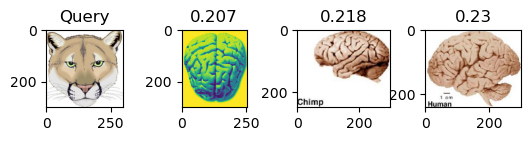

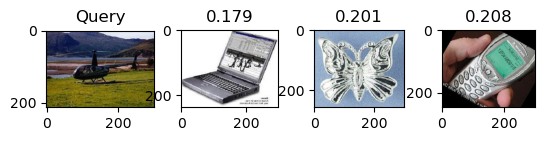

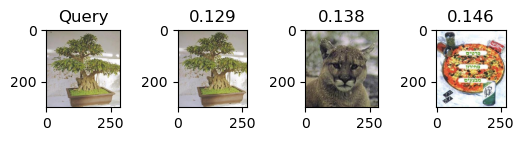

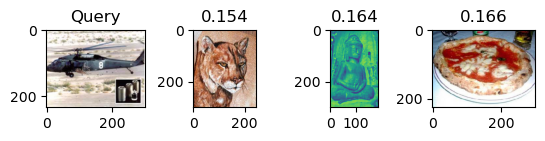

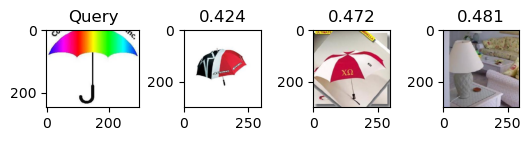

In [45]:
print('Results with Bhattacharyya_Distance:')
RunPredictionsWithMethod(Bhattacharyya_Distance)

Results with Kullback_Leibler_Divergence:


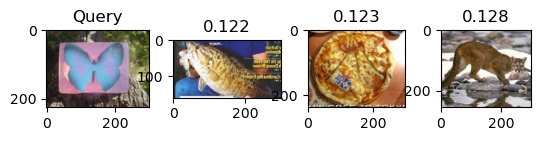

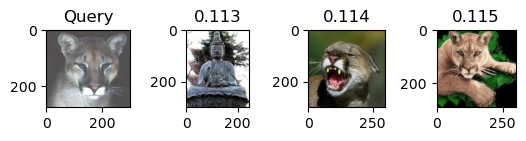

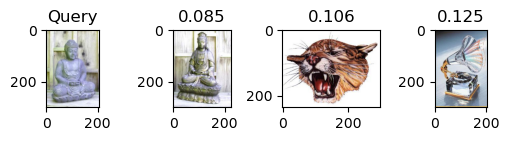

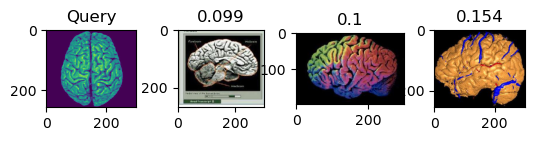

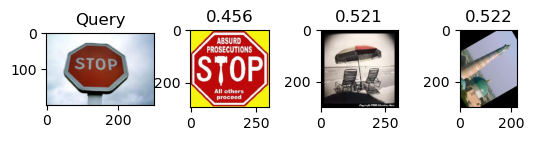

In [46]:
print('Results with Kullback_Leibler_Divergence:')
RunPredictionsWithMethod(Kullback_Leibler_Divergence)

In [47]:
# TF-IDF method
# idk if this is correct, but it's a start

# Number of documents (images)
num_docs = train_histograms.shape[0]
# Precompute IDF for each cluster
idf = np.log((num_docs + 1) / (np.count_nonzero(train_histograms > 0, axis=0) + 1)) + 1
# Compute TF for each histogram
tf = train_histograms / train_histograms.sum(axis=1, keepdims=True)

# Compute TF-IDF for each histogram
training_tfidf_vectors = tf * idf
print(training_tfidf_vectors.shape)
print("Training TF-IDF contains NaN:", np.isnan(training_tfidf_vectors).any())

(1104, 50)
Training TF-IDF contains NaN: False


In [48]:
def TF_IDF(hist1, hist2, test_idx, train_idx):
    hist1_tf = hist1 / np.sum(hist1) # Compute TF for the test histogram
    hist1_tfidf = hist1_tf * idf # Compute TF-IDF for the test histogram
    return cosine_similarity(hist1_tfidf.reshape(1, -1), training_tfidf_vectors[train_idx].reshape(1, -1))

Results with TF_IDF:


C:\Users\jkeir\AppData\Local\Temp\ipykernel_34096\3449646847.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities = np.array(similarities, dtype=[('similarity', float), ('index', int)])
C:\Users\jkeir\AppData\Local\Temp\ipykernel_34096\3449646847.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities = np.array(similarities, dtype=[('similarity', float), ('index', int)])
C:\Users\jkeir\AppData\Local\Temp\ipykernel_34096\3449646847.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing 

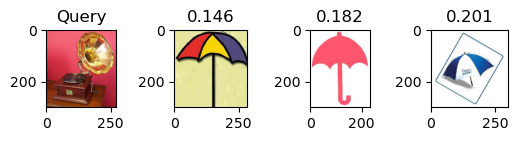

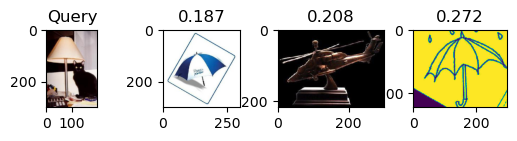

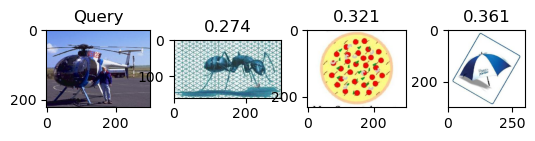

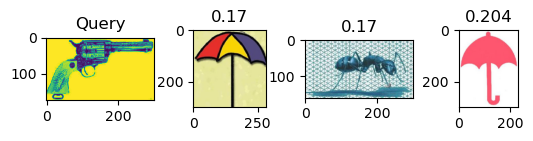

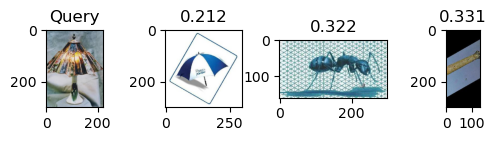

In [49]:
print('Results with TF_IDF:')
RunPredictionsWithMethod(TF_IDF)